<a href="https://colab.research.google.com/github/spch88/my_project/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой работе 
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым 

Ссылка на архив: https://storage.googleapis.com/datasets_ai/Data/writers25.zip

In [ ]:
# Работа с массивами данных
import numpy as np 

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# Рисование схемы модели
#from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
#from IPython.display import display

%matplotlib inline

In [ ]:
gdown.download('https://storage.googleapis.com/datasets_ai/Data/writers25.zip', None, quiet=True)

'writers25.zip'

In [ ]:
# Распаковка архива в папку writers
!unzip -qo writers25.zip -d writers25/

In [ ]:
# Просмотр содержимого папки
!ls writers25/rec_1d/writters

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [ ]:
file_dir = './writers25/rec_1d/writters'
file_list = os.listdir('./writers25/rec_1d/writters')
file_list.sort()

class_list = []
text_data = []

# заполняем список классов
for file in file_list:
  class_list.append(file[:-4])

# считываем тексты произведений из файлов
for cls in class_list:
  text_data.append('')
  with open(f'{file_dir}/{cls}.txt', 'r', encoding='cp1251') as f:
    text = f.read()
    text_data[class_list.index(cls)] += ' ' + text.replace('\n', ' ')
    text_data[class_list.index(cls)] = text_data[class_list.index(cls)]

    print(f'Писатель: {cls} (фрагмент текста)')
    print(text_data[class_list.index(cls)][:200])
    print(f'Размер (символов): {len(text_data[class_list.index(cls)])}')
    print('')

class_count = len(class_list)    

Писатель: Беляев (фрагмент текста)
 Часть первая  I. На палубе   Большой трансатлантический пароход «Вениамин Франклин» стоял в генуэзской гавани, готовый к отплытию. На берегу была обычная суета, слышались крики разноязычной, пестрой 
Размер (символов): 2255254

Писатель: Булгаков (фрагмент текста)
 Черновики романа. Тетрадь 1 1928 - 1929 гг. РАЗГОВОР ПО ДУШАМ - Значит, гражданин Поротый, две тысячи рублей вы уплатили гражданину Иванову за дом в Серпухове? - Да, так. Так точно, - уплатил я. Толь
Размер (символов): 2001064

Писатель: Васильев (фрагмент текста)
 А зори здесь тихие…1  В списках не значилсяЧасть первая1   На 171-м разъезде уцелело двенадцать дворов, пожарный сарай да приземистый, длинный пакгауз, выстроенный в начале века из подогнанных валуно
Размер (символов): 2952792

Писатель: Гоголь (фрагмент текста)
 Гоголь Николай Васильевич. Мертвые души. Поэма.  We may guess that it was a pretty apt expression, since long after the man had become lost to view Chichikov was still 

In [ ]:
# разделим тексты на обучающие и тестовые выборки
test_train, test_test = [],[]
for i in range(len(class_list)):
  n_div = int(len(text_data[i])*0.8)
  test_train.append(text_data[i][:n_div])
  test_test.append(text_data[i][n_div:])
  print(class_list[i])
  print(f'Размер тренировочной выборки: {len(test_train[i])}')
  print(f'Размер тестовой выборки: {len(test_test[i])}')
  print('')

Беляев
Размер тренировочной выборки: 1804203
Размер тестовой выборки: 451051

Булгаков
Размер тренировочной выборки: 1600851
Размер тестовой выборки: 400213

Васильев
Размер тренировочной выборки: 2362233
Размер тестовой выборки: 590559

Гоголь
Размер тренировочной выборки: 1572095
Размер тестовой выборки: 393024

Гончаров
Размер тренировочной выборки: 2483769
Размер тестовой выборки: 620943

Горький
Размер тренировочной выборки: 2018704
Размер тестовой выборки: 504676

Грибоедов
Размер тренировочной выборки: 775287
Размер тестовой выборки: 193822

Достоевский
Размер тренировочной выборки: 4143160
Размер тестовой выборки: 1035790

Каверин
Размер тренировочной выборки: 1594264
Размер тестовой выборки: 398566

Катаев
Размер тренировочной выборки: 2063396
Размер тестовой выборки: 515850

Куприн
Размер тренировочной выборки: 1863120
Размер тестовой выборки: 465780

Лермонтов
Размер тренировочной выборки: 1578032
Размер тестовой выборки: 394509

Лесков
Размер тренировочной выборки: 1721770


In [ ]:
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)

    x, y = [], []

    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)


# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=class_list,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)


In [ ]:
# зададим параметры преобразования текста
vocab_size = 30000        # размер словаря
win_size = 1000           # ширина окна
win_hof = 100             # шаг

# создаем токенизатор и строим частотный словарь по текстам
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', 
                      oov_token='unknown', char_level=False)

# построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_data)
    
# преобразуем обучающие и проверочные тексты в последовательности индексов согласно частотному словарю 
seq_train = tokenizer.texts_to_sequences(test_train)
seq_test = tokenizer.texts_to_sequences(test_test)
   
# построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

print(f'Объем словаря: {len(items)}')

Объем словаря: 346145


In [ ]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train, win_size, win_hof) 
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, win_size, win_hof)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(69083, 1000) (69083, 20)
(17225, 1000) (17225, 20)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 30)          900000    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 1000, 30)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_20 (Bat  (None, 1000, 30)         120       
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (None, 1000, 20)          3020      
                                                                 
 conv1d_21 (Conv1D)          (None, 996, 20)           2020      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 498, 20)        

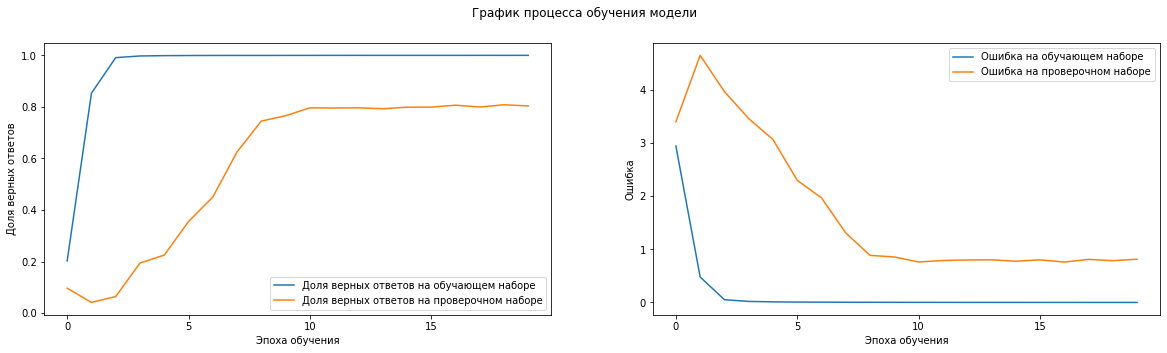

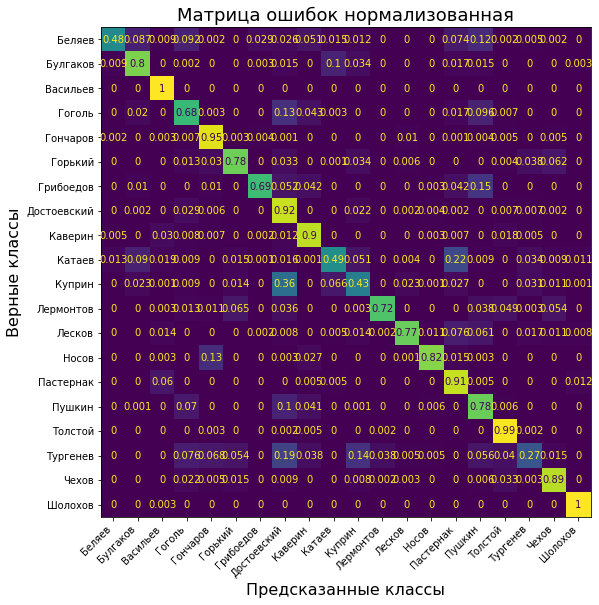

----------------------------------------------------------------------------------------------------
Класс: Беляев                48% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Булгаков              80% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Гоголь                68% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Гончаров              95% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Горький               78% сеть отнесла к классу Горький              - ВЕРНО :-)
Класс: Грибоедов             69% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Достоевский           92% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Каверин               90% сеть отнесла к классу Каверин              - ВЕРНО :-)
Класс: Катаев                50% сеть отнесла к классу Катаев               - ВЕРНО :-)
Класс: Куприн      

In [ ]:
# создание модели НС, обучение и получение результатов
model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=win_size))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(Conv1D(20, 5, activation='relu', padding='same'))
model.add(Conv1D(20, 5, activation='relu'))
model.add(MaxPooling1D(2)) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(class_count, activation='softmax'))

compile_train_eval_model(model,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='adam',
                         epochs=20,
                         batch_size=1000,
                         class_labels=class_list)

Проверим к кому из перечисленных писателей ближе тестовый текст:

In [ ]:
# размещение тестового текста
file_dir_test = './writers25/rec_1d/refer'
file_list_test = os.listdir('./writers25/rec_1d/refer')

text_data_test = ['']

# считываем тестовый текст
with open(f'{file_dir_test}/{file_list_test[0]}', 'r', encoding='cp1251') as f:
  text = f.read()
  text_data_test[0] += ' ' + text.replace('\n', ' ')

  print(f'Писатель: {file_list_test[0][:-4]} (фрагмент текста)')
  print(text_data_test[:200])
  print(f'Размер (символов): {len(text_data_test)}')
  print('')

Писатель: островский (фрагмент текста)
[' ВВЕДЕНИЕ «Гроза» – одна из самых ярких, необычных и острых по проблематике  пьес русского репертуара. На  протяжении почти полутора столетий отношение к драме не устоялось, каждая новая театральная постановка открывала что-то новое в поэтике и в содержании «Грозы», неизменно вызывая интерес к этому загадочному творению А.Н. Островского. Одним виделся свет, глубокая поэзия, другим – тяжесть, мрачность, безысходность. Одни восхищаются созданным А.Н. Островским характером главной героини, видя в ней чистоту женской души, другим поступки Катерины кажутся бессмысленными, глупыми и даже безнравственными. Как видно, основные суждения развиваются в русле давно высказанных Добролюбовым, Григорьевым и Писаревым оценок. [2, с.296]  Сейчас трудно встретить человека, не читавшего драму «Гроза» или не слышавшего об этой пьесе ничего. Актуальность во многом обусловлена тем, что детальное рассмотрение  проблем, поднимаемых автором в пьесе, будет способствовать

In [ ]:
# преобразуем тестовый текст для обработки моделью 
my_seq_test = tokenizer.texts_to_sequences(text_data_test)
pad_sec_text = sequence.pad_sequences(my_seq_test, x_test.shape[1])

# применим предсказательный механизм к тестовым данным
print(class_list[np.argmax(model.predict(pad_sec_text))])

Васильев
